# packages

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import sys
import vectorbt as vbt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas_ta as ta
import pickle
import itertools
sys.path.insert(0, '../scripts')

In [3]:
from strategies import HigherHighStrategy

# data

In [3]:
symbols = pd.read_pickle('../data/top500_symbols.pickle')
symbols[:10]

['TSLA', 'NVDA', 'AAPL', 'SPY', 'SOXL', 'AMD', 'QQQ', 'AMZN', 'TQQQ', 'INTC']

In [4]:
data= yf.download(symbols[:10], start=datetime(2000, 1,1), end=datetime.now())

[*********************100%%**********************]  10 of 10 completed


In [5]:
data

Adj Close                                                 \
                  AAPL         AMD        AMZN       INTC        NVDA   
Date                                                                    
2000-01-03    0.843077   15.500000    4.468750  24.710663    0.089440   
2000-01-04    0.771997   14.625000    4.096875  23.556787    0.087052   
2000-01-05    0.783294   15.000000    3.487500  23.752048    0.084186   
2000-01-06    0.715509   16.000000    3.278125  22.367405    0.078692   
2000-01-07    0.749401   16.250000    3.478125  23.290503    0.080007   
...                ...         ...         ...        ...         ...   
2025-01-10  236.850006  116.040001  218.940002  19.150000  135.910004   
2025-01-13  234.399994  117.320000  218.460007  19.200001  133.229996   
2025-01-14  233.279999  116.089996  217.759995  19.200001  131.759995   
2025-01-15  237.869995  119.959999  223.350006  19.719999  136.240005   
2025-01-16  232.330002  118.708000  223.220001  19.535000  136.619995   

                                                                      ...  \
                   QQQ       SOXL         SPY       TQQQ        TSLA  ...   
Date                                                                  ...   
2000-01-03   80.434052        NaN   92.692924        NaN         NaN  ...   
2000-01-04   74.916161        NaN   89.068054        NaN         NaN  ...   
2000-01-05   73.006104        NaN   89.227379        NaN         NaN  ...   
2000-01-06   67.992249        NaN   87.793404        NaN         NaN  ...   
2000-01-07   76.401779        NaN   92.892082        NaN         NaN  ...   
...                ...        ...         ...        ...         ...  ...   
2025-01-10  507.190002  28.059999  580.489990  76.830002  394.739990  ...   
2025-01-13  505.559998  27.850000  581.390015  76.029999  403.309998  ...   
2025-01-14  505.079987  28.120001  582.190002  75.760002  396.359985  ...   
2025-01-15  516.700012  29.940001  592.780029  80.879997  428.220001  ...   
2025-01-16  516.139526  30.790400  592.451721  80.660698  414.109802  ...   

               Volume                                                      \
                 AAPL       AMD       AMZN      INTC       NVDA       QQQ   
Date                                                                        
2000-01-03  535796800   7843200  322352000  57710200  300912000  36345200   
2000-01-04  512377600   6290200  349748000  51019600  300480000  33786600   
2000-01-05  778321600   8204600  769148000  52389000  188352000  42496600   
2000-01-06  767972800  11489400  375040000  55171200  120480000  37134800   
2000-01-07  460734400   8543400  210108000  41096400   71184000  28138200   
...               ...       ...        ...       ...        ...       ...   
2025-01-10   61710900  59415600   36811500  71244600  207602500  40532500   
2025-01-13   49630700  39128900   27262700  50669000  204808900  31694200   
2025-01-14   39435300  37005300   24711700  47147500  195590500  33737200   
2025-01-15   39783600  38097600   31229300  56202700  184599500  34811500   
2025-01-16   13831192  11170018    5527649  11342555   66044556   7223978   

                                                          
                  SOXL       SPY        TQQQ        TSLA  
Date                                                      
2000-01-03         NaN   8164300         NaN         NaN  
2000-01-04         NaN   8089800         NaN         NaN  
2000-01-05         NaN  12177900         NaN         NaN  
2000-01-06         NaN   6227200         NaN         NaN  
2000-01-07         NaN   8066500         NaN         NaN  
...                ...       ...         ...         ...  
2025-01-10  85395000.0  73105000  72825800.0  62287300.0  
2025-01-13  68286400.0  47910100  56691000.0  67580500.0  
2025-01-14  79759400.0  48420600  62635500.0  84565000.0  
2025-01-15  69155400.0  56812600  53138300.0  80876000.0  
2025-01-16  32909006.0   8502704  17774924.0  25427536.0  

[6299

In [5]:
data.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AMD', 'AMZN', 'INTC', 'NVDA', 'QQQ', 'SOXL', 'SPY', 'TQQQ', 'TSLA']])

In [4]:
symbol = 'AAPL'
strategy = 'hhhl'
close_price = data.loc[:, ('Adj Close', symbol)]
open_price = data.loc[:, ('Open', symbol)]

# generate trades dataset

In [7]:
strategy_params = {'fees': 0.001,
                    'slippage': 0.0001,
                    'stop_loss': 0.1}
param_ranges = {'window_entry': [2, 9],
                'hh_hl_counts': [1, 5],
                'window_exit': [2, 9],
                'lh_counts': [1, 5]}
param_ranges = {key: np.arange(value[0], value[1] + 1) for key, value in param_ranges.items()}

if strategy == 'hhhl':
    Strategy = HigherHighStrategy
    
indicator = Strategy.run(close_price, **param_ranges, param_product = True)
entries = indicator.entry_signal
exits = indicator.exit_signal

entries.columns.names = [param[7:] if 'custom_' in param else param for param in entries.columns.names]
exits.columns.names = [param[7:] if 'custom_' in param else param for param in exits.columns.names]

pf = vbt.Portfolio.from_signals(close_price, 
                                entries, 
                                exits,
                                price = open_price,
                                #fees=strategy_params['fees'], 
                                #slippage=strategy_params['slippage'], 
                                sl_stop = strategy_params['stop_loss'], 
                                freq='1D')
df_stats = pf.stats(agg_func=None)
df_stats['Max Drawdown Duration'] = df_stats['Max Drawdown Duration'].dt.days
df_stats['Total Trades per year'] = df_stats['Total Trades']*360/len(open_price)

In [8]:
df_trades = pf.entry_trades.records_readable
df_trades

,Entry Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,"(2, 1, 2, 1)",112.000016,2000-01-14,0.892857,0.0,2000-01-24,0.968192,0.0,8.437517,0.084375,Long,Closed,0
1,1,"(2, 1, 2, 1)",116.849133,2000-02-04,0.928013,0.0,2000-02-09,1.018973,0.0,10.628593,0.098016,Long,Closed,1
2,2,"(2, 1, 2, 1)",115.708477,2000-02-15,1.029018,0.0,2000-02-16,1.051339,0.0,2.582727,0.021692,Long,Closed,2
3,3,"(2, 1, 2, 1)",114.915481,2000-03-01,1.058594,0.0,2000-03-06,1.125000,0.0,7.631079,0.062730,Long,Closed,3
4,4,"(2, 1, 2, 1)",120.535652,2000-03-17,1.072545,0.0,2000-03-24,1.271763,0.0,24.012861,0.185743,Long,Closed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233870,233870,"(9, 5, 9, 5)",4.790489,2023-12-15,197.529999,0.0,2023-12-19,196.160004,0.0,-6.562946,-0.006936,Long,Closed,233870
233871,233871,"(9, 5, 9, 5)",4.933597,2024-05-16,190.470001,0.0,2024-05-30,190.759995,0.0,1.430710,0.001523,Long,Closed,233871
233872,233872,"(9, 5, 9, 5)",4.538424,2024-06-12,207.369995,0.0,2024-06-24,207.720001,0.0,1.588476,0.001688,Long,Closed,233872
233873,233873,"(9, 5, 9, 5)",4.136013,2024-07-09,227.929993,0.0,2024-07-22,227.009995,0.0,-3.805125,-0.004036,Long,Closed,233873


<Axes: xlabel='Entry Timestamp'>

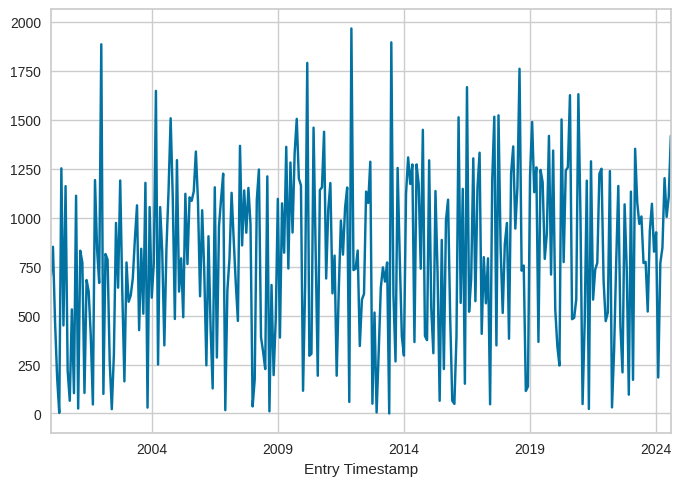

In [9]:
df_trades.groupby('Entry Timestamp')['Return'].count().resample('M').sum().plot()

# create ml dataset - simple

In [10]:
df_trades[['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts']] = df_trades['Column'].tolist()
df1 = df_trades.loc[:, ['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts']]
df1['positive_return'] = df_trades['Return'] > 0
df1.head()

,window_entry,hh_hl_counts,window_exit,lh_counts,positive_return
0,2,1,2,1,True
1,2,1,2,1,True
2,2,1,2,1,True
3,2,1,2,1,True
4,2,1,2,1,True


In [11]:
df1['positive_return'].value_counts()

True     159284
False     74429
Name: positive_return, dtype: int64

In [12]:
x = df1.iloc[:, :4]
y = df1.iloc[:, -1]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)


# model train & eval

In [14]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
clf.fit(x_train, y_train)


HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

In [15]:
#clf.feature_importances_

## test data

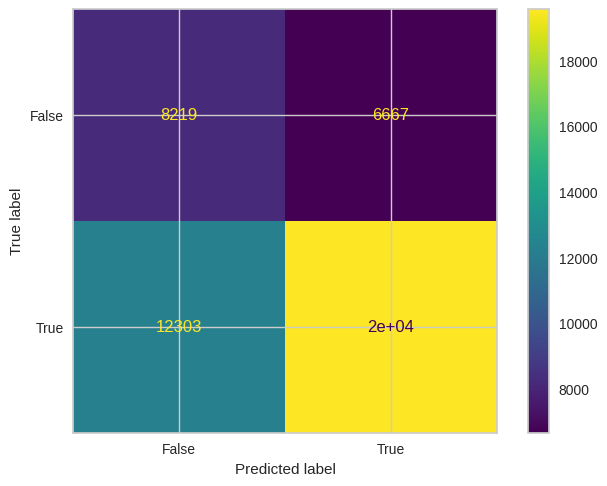

In [15]:
y_test_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels= clf.classes_)
cmd.plot()


In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.40      0.55      0.46     14886
        True       0.75      0.61      0.67     31857

    accuracy                           0.59     46743
   macro avg       0.57      0.58      0.57     46743
weighted avg       0.64      0.59      0.61     46743



In [17]:
pd.Series(y_test_pred).value_counts()

True     26221
False    20522
dtype: int64

## train data

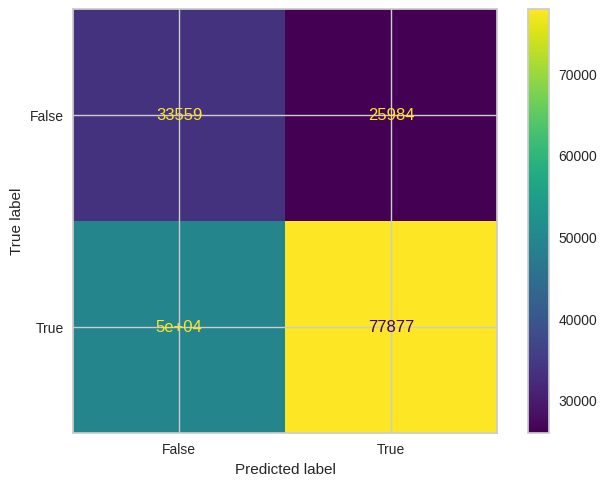

In [18]:
y_train_pred = clf.predict(x_train)
cm = confusion_matrix(y_train, y_train_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels= clf.classes_)
cmd.plot()

In [19]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.40      0.56      0.47     59543
        True       0.75      0.61      0.67    127427

    accuracy                           0.60    186970
   macro avg       0.58      0.59      0.57    186970
weighted avg       0.64      0.60      0.61    186970



In [20]:
pd.Series(y_train_pred).value_counts()

True     103861
False     83109
dtype: int64

# create ml dataset - incl tech indicators

In [8]:
df_price = data.loc[:, (slice(None), 'AAPL')].droplevel(1, axis = 'columns')
df_price

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,0.844004,0.999442,1.004464,0.907924,0.936384,535796800
2000-01-04,0.772846,0.915179,0.987723,0.903460,0.966518,512377600
2000-01-05,0.784155,0.928571,0.987165,0.919643,0.926339,778321600
2000-01-06,0.716296,0.848214,0.955357,0.848214,0.947545,767972800
2000-01-07,0.750226,0.888393,0.901786,0.852679,0.861607,460734400
...,...,...,...,...,...,...
2024-09-25,226.369995,226.369995,227.289993,224.020004,224.929993,42308700
2024-09-26,227.520004,227.520004,228.500000,225.410004,227.300003,36636700
2024-09-27,227.789993,227.789993,229.520004,227.300003,228.460007,34026000


In [22]:
df_price.ta.strategy('All')

0it [00:00, ?it/s]/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
131it [00:03, 33.42it/s]


In [23]:
df_price

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.844004,0.999442,1.004464,0.907924,0.936384,535796800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.970610,NaN,0.977818,NaN,NaN,NaN,NaN
2000-01-04,0.772846,0.915179,0.987723,0.903460,0.966518,512377600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.935454,NaN,0.930385,NaN,NaN,NaN,NaN
2000-01-05,0.784155,0.928571,0.987165,0.919643,0.926339,778321600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.945126,NaN,0.940987,NaN,NaN,NaN,NaN
2000-01-06,0.716296,0.848214,0.955357,0.848214,0.947545,767972800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.883928,NaN,0.875000,NaN,NaN,NaN,NaN
2000-01-07,0.750226,0.888393,0.901786,0.852679,0.861607,460734400,0.923214,NaN,NaN,NaN,...,NaN,NaN,NaN,0.880953,NaN,0.882813,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-27,228.029999,228.029999,228.850006,224.889999,226.000000,35934600,226.380665,231.217702,221.543629,4.837037,...,219.709124,1.306567,0.657424,227.256668,225.652567,227.450001,-4.095940,226.457633,227.318622,1.240801
2024-08-28,226.490005,226.490005,229.860001,225.679993,227.919998,38052200,226.553999,231.347233,221.760764,4.793235,...,220.289274,1.281238,0.640521,227.343333,226.165985,227.130001,-18.837313,226.585453,227.524329,0.999636
2024-08-29,229.789993,229.789993,232.919998,228.880005,230.100006,51906300,227.541999,232.444351,222.639647,4.902352,...,221.110156,1.228037,0.596830,230.529999,226.822151,230.344997,-18.071630,227.226543,228.472631,1.505764


In [24]:
df_trades[['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts']] = df_trades['Column'].tolist()
df2 = df_trades.loc[:, ['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts', 'Entry Timestamp']]
df2['positive_return'] = df_trades['Return'] > 0
df2.set_index('Entry Timestamp', inplace = True)
df2 = df_price.shift(1).join(df2, how = 'right') # shift lebo den otvorenia pozicie berie close price + stats predosleho dna
df2 = df2.loc[df2['positive_return'].notna(),:]
df2

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,window_entry,hh_hl_counts,window_exit,lh_counts,positive_return
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,2,1,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,2,2,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,3,1,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,3,2,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,3,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,229.789993,229.789993,232.919998,228.880005,230.100006,5.190630e+07,227.541999,232.444351,222.639647,4.902352,...,230.344997,-18.07163,227.226543,228.472631,1.505764,5,4,2,2,False
2024-08-30,229.789993,229.789993,232.919998,228.880005,230.100006,5.190630e+07,227.541999,232.444351,222.639647,4.902352,...,230.344997,-18.07163,227.226543,228.472631,1.505764,5,4,4,3,False
2024-08-30,229.789993,229.789993,232.919998,228.880005,230.100006,5.190630e+07,227.541999,232.444351,222.639647,4.902352,...,230.344997,-18.07163,227.226543,228.472631,1.505764,5,4,5,3,False
2024-08-30,229.789993,229.789993,232.919998,228.880005,230.100006,5.190630e+07,227.541999,232.444351,222.639647,4.902352,...,230.344997,-18.07163,227.226543,228.472631,1.505764,5,4,6,3,False


In [25]:
df2.to_csv('../data/hhhl_ml_dataset_extended.csv', header = True, index = True)

In [26]:
x = df2.iloc[:, :-1]
y = df2.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# model train & eval

In [27]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
clf.fit(x_train, y_train)


HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

In [29]:
#clf.feature_importances_

## test data

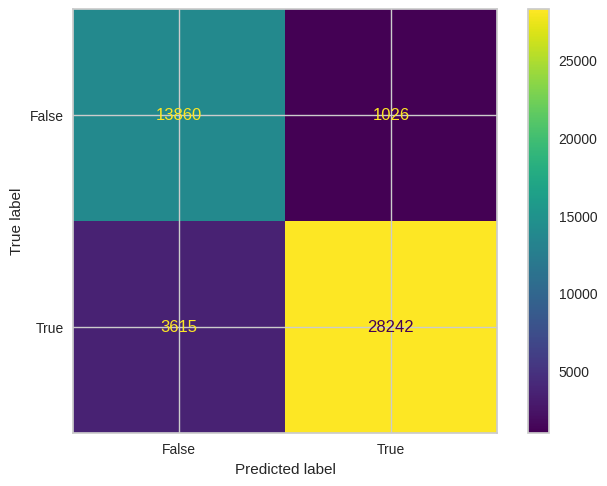

In [28]:
y_test_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels= clf.classes_)
cmd.plot()


In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.79      0.93      0.86     14886
        True       0.96      0.89      0.92     31857

    accuracy                           0.90     46743
   macro avg       0.88      0.91      0.89     46743
weighted avg       0.91      0.90      0.90     46743



In [30]:
pd.Series(y_test_pred).value_counts()

True     29268
False    17475
dtype: int64

## train data

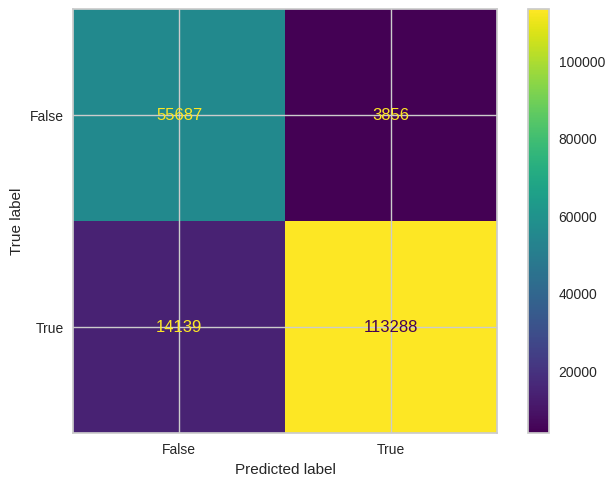

In [31]:
y_train_pred = clf.predict(x_train)
cm = confusion_matrix(y_train, y_train_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels= clf.classes_)
cmd.plot()

In [32]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.80      0.94      0.86     59543
        True       0.97      0.89      0.93    127427

    accuracy                           0.90    186970
   macro avg       0.88      0.91      0.89    186970
weighted avg       0.91      0.90      0.91    186970



In [33]:
pd.Series(y_train_pred).value_counts()

True     117144
False     69826
dtype: int64

# walk-forward - simple

In [68]:
x = df2.iloc[:, :-1]
y = df2.iloc[:, -1]
tscv = TimeSeriesSplit(n_splits=6,test_size=30_000)

In [71]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

for train_index, test_index in tscv.split(x):
    print(train_index, test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(len(x_train), len(x_test))
    clf.fit(x_train, y_train)    
    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')

[    0     1     2 ... 53710 53711 53712] [53713 53714 53715 ... 83710 83711 83712]
53713 30000
--- train ---
              precision    recall  f1-score   support

       False       0.90      0.97      0.94     18345
        True       0.99      0.94      0.96     35368

    accuracy                           0.95     53713
   macro avg       0.94      0.96      0.95     53713
weighted avg       0.96      0.95      0.96     53713

--- test ---
              precision    recall  f1-score   support

       False       0.50      0.86      0.63      7342
        True       0.94      0.73      0.82     22658

    accuracy                           0.76     30000
   macro avg       0.72      0.79      0.73     30000
weighted avg       0.83      0.76      0.77     30000

----------------------------------------------------------------------------------------------------
[    0     1     2 ... 83710 83711 83712] [ 83713  83714  83715 ... 113710 113711 113712]
83713 30000
--- train ---
      

# walk-forward - CV

In [76]:
x = df2.iloc[:, :-1]
y = df2.iloc[:, -1]
tscv = TimeSeriesSplit(n_splits=6,test_size=30_000)

In [82]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_iter': [100, 200, 300],
#     'max_depth': [None, 3, 5],
#     'min_samples_leaf': [20, 50, 100],
#     'l2_regularization': [0.0, 0.1, 1.0],
#     'max_leaf_nodes': [31, 50, 100],
# }
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1]
}

In [84]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,  
    scoring='f1',
    n_jobs=-1, 
    verbose=1
)

for train_index, test_index in tscv.split(x):
    print(train_index, test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(len(x_train), len(x_test))
    grid_search.fit(x_train, y_train)    
    y_pred_test = grid_search.predict(x_test)
    y_pred_train = grid_search.predict(x_train)
    print(grid_search.best_params_)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')

[    0     1     2 ... 53710 53711 53712] [53713 53714 53715 ... 83710 83711 83712]
53713 30000
Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 200, 'min_samples_leaf': 50}
--- train ---
              precision    recall  f1-score   support

       False       0.74      0.87      0.80     18345
        True       0.93      0.84      0.88     35368

    accuracy                           0.85     53713
   macro avg       0.83      0.86      0.84     53713
weighted avg       0.86      0.85      0.85     53713

--- test ---
              precision    recall  f1-score   support

       False       0.50      0.83      0.62      7342
        True       0.93      0.73      0.82     22658

    accuracy                           0.76     30000
   macro avg       0.71      0.78      0.72     30000
weighted avg       0.82      0.76      0.77     30000

------------------------------------------------------

# temporal normalization - before tech ind addition

## data prep

In [34]:
def normalize(series, window):
    series_min = series.rolling(window=window, closed = 'left').min()
    series_max = series.rolling(window=window, closed = 'left').max()
    
    # Calculate the normalized value based on the ratio to the range
    series_norm = ((series - series_min)/(series_max - series_min))*(1000 - 100) + 100

    return series_norm
window = 100
df_price_norm = df_price.iloc[:, :6]
df_price_norm = df_price_norm.apply(lambda x: normalize(x, window)).iloc[window:, :]
df_price_norm


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-05-25,122.402860,122.403026,143.144868,147.368937,137.001235,221.285845
2000-05-26,108.671658,108.671810,101.855612,135.527625,128.999873,97.948770
2000-05-30,126.980618,126.980749,75.876248,80.264515,123.000268,390.135759
2000-05-31,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371
2000-06-01,176.635136,176.635732,120.783353,78.754969,29.000965,494.199023
...,...,...,...,...,...,...
2024-08-27,916.145511,912.474835,893.519830,893.059008,867.397757,123.468368
2024-08-28,896.334991,892.623878,906.353305,903.361776,891.691285,132.286704
2024-08-29,938.786133,935.161671,945.235102,945.095021,919.274687,189.979428


<Axes: xlabel='Date'>

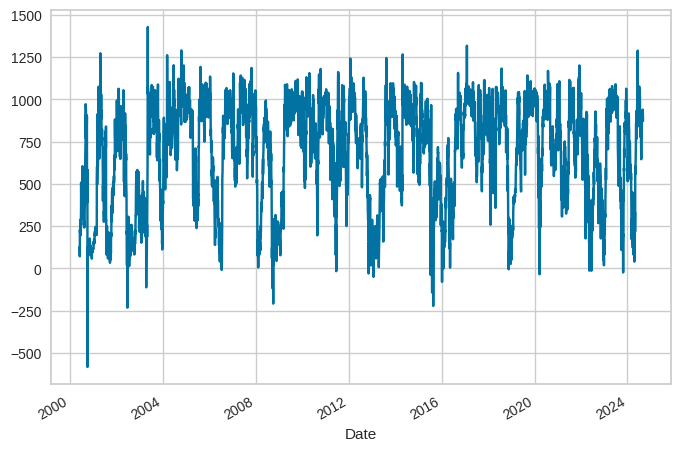

In [35]:
df_price_norm['Adj Close'].plot()

In [36]:
mask = (df_price_norm > 0).all(axis = 1)
df_price_norm = df_price_norm[mask]
df_price_norm.shape

(6054, 6)

In [37]:
df_price_norm.ta.strategy('All')
df_price_norm

0it [00:00, ?it/s]/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
/tmp/ipykernel_33332/4114344545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_norm.ta.strategy('All')
/tmp/ipykernel_33332/4114344545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,
2000-05-25,122.402860,122.403026,143.144868,147.368937,137.001235,221.285845,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,137.638944,NaN,133.829964,NaN,NaN,NaN,NaN
2000-05-26,108.671658,108.671810,101.855612,135.527625,128.999873,97.948770,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,115.351683,NaN,113.681714,NaN,NaN,NaN,NaN
2000-05-30,126.980618,126.980749,75.876248,80.264515,123.000268,390.135759,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,94.373837,NaN,102.525565,NaN,NaN,NaN,NaN
2000-05-31,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,116.367784,NaN,105.289758,NaN,NaN,NaN,NaN
2000-06-01,176.635136,176.635732,120.783353,78.754969,29.000965,494.199023,117.824720,NaN,NaN,NaN,...,NaN,NaN,NaN,125.391351,NaN,138.202446,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-27,916.145511,912.474835,893.519830,893.059008,867.397757,123.468368,888.412388,924.118019,852.706758,35.705630,...,832.017359,1.150920,1.119812,899.684557,882.060044,902.882127,9.030118,892.206590,903.257743,1.240801
2024-08-28,896.334991,892.623878,906.353305,903.361776,891.691285,132.286704,890.630027,924.562820,856.697235,33.932792,...,837.202654,1.074540,1.185945,900.779653,888.442910,898.740709,-7.552289,893.854221,905.917959,0.999636
2024-08-29,938.786133,935.161671,945.235102,945.095021,919.274687,189.979428,903.359748,938.537769,868.181726,35.178021,...,845.666516,0.886915,1.113791,941.830598,897.388551,940.163366,-5.811628,902.118056,918.148872,1.505764


In [38]:
df3 = df_trades.loc[:, ['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts', 'Entry Timestamp']]
df3['positive_return'] = (df_trades['Return'] > 0).astype('int')
df3.set_index('Entry Timestamp', inplace = True)
df3 = df_price_norm.shift(1).join(df3) # shift lebo den otvorenia pozicie berie close price + stats predosleho dna
df3 = df3.loc[(df3['positive_return'].notna()) & (df3['Adj Close'].notna()),:]
df3

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,window_entry,hh_hl_counts,window_exit,lh_counts,positive_return
2000-06-01,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371,NaN,NaN,NaN,NaN,...,105.289758,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,1.0
2000-06-01,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371,NaN,NaN,NaN,NaN,...,105.289758,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,1.0
2000-06-01,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371,NaN,NaN,NaN,NaN,...,105.289758,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0,1.0
2000-06-01,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371,NaN,NaN,NaN,NaN,...,105.289758,NaN,NaN,NaN,NaN,2.0,1.0,3.0,2.0,1.0
2000-06-01,72.055811,72.055682,145.181050,131.866618,111.001057,237.651371,NaN,NaN,NaN,NaN,...,105.289758,NaN,NaN,NaN,NaN,2.0,1.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,938.786133,935.161671,945.235102,945.095021,919.274687,189.979428,903.359748,938.537769,868.181726,35.178021,...,940.163366,-5.811628,902.118056,918.148872,1.505764,5.0,4.0,2.0,2.0,0.0
2024-08-30,938.786133,935.161671,945.235102,945.095021,919.274687,189.979428,903.359748,938.537769,868.181726,35.178021,...,940.163366,-5.811628,902.118056,918.148872,1.505764,5.0,4.0,4.0,3.0,0.0
2024-08-30,938.786133,935.161671,945.235102,945.095021,919.274687,189.979428,903.359748,938.537769,868.181726,35.178021,...,940.163366,-5.811628,902.118056,918.148872,1.505764,5.0,4.0,5.0,3.0,0.0
2024-08-30,938.786133,935.161671,945.235102,945.095021,919.274687,189.979428,903.359748,938.537769,868.181726,35.178021,...,940.163366,-5.811628,902.118056,918.148872,1.505764,5.0,4.0,6.0,3.0,0.0


## wf

In [161]:
x = df3.iloc[:, :-1]
y = df3.iloc[:, -1]
tscv = TimeSeriesSplit(n_splits=6, test_size=30_000)

In [162]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

for train_index, test_index in tscv.split(x):
    print(train_index, test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(len(x_train), len(x_test))
    clf.fit(x_train, y_train)    
    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')

[    0     1     2 ... 51490 51491 51492] [51493 51494 51495 ... 81490 81491 81492]
51493 30000
--- train ---
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94     17380
         1.0       0.99      0.95      0.97     34113

    accuracy                           0.95     51493
   macro avg       0.94      0.96      0.95     51493
weighted avg       0.96      0.95      0.96     51493

--- test ---
              precision    recall  f1-score   support

         0.0       0.57      0.56      0.56      7342
         1.0       0.86      0.86      0.86     22658

    accuracy                           0.79     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.79      0.79      0.79     30000

----------------------------------------------------------------------------------------------------
[    0     1     2 ... 81490 81491 81492] [ 81493  81494  81495 ... 111490 111491 111492]
81493 30000
--- train ---
      

/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract



--- train ---
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88     54379
         1.0       0.97      0.91      0.94    117114

    accuracy                           0.92    171493
   macro avg       0.90      0.93      0.91    171493
weighted avg       0.93      0.92      0.92    171493

--- test ---
              precision    recall  f1-score   support

         0.0       0.48      0.79      0.59      8604
         1.0       0.88      0.65      0.75     21396

    accuracy                           0.69     30000
   macro avg       0.68      0.72      0.67     30000
weighted avg       0.77      0.69      0.71     30000

----------------------------------------------------------------------------------------------------
[     0      1      2 ... 201490 201491 201492] [201493 201494 201495 ... 231490 231491 231492]
201493 30000


/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract



--- train ---
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87     62983
         1.0       0.97      0.90      0.93    138510

    accuracy                           0.91    201493
   macro avg       0.89      0.92      0.90    201493
weighted avg       0.92      0.91      0.91    201493

--- test ---
              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67     10135
         1.0       0.85      0.78      0.81     19865

    accuracy                           0.76     30000
   macro avg       0.74      0.75      0.74     30000
weighted avg       0.77      0.76      0.77     30000

----------------------------------------------------------------------------------------------------


## wf CV

In [39]:
x = df3.iloc[:, :-1]
y = df3.iloc[:, -1]
tscv = TimeSeriesSplit(n_splits=6,test_size=30_000)

In [44]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_iter': [100, 200, 300],
#     'max_depth': [None, 3, 5],
#     'min_samples_leaf': [20, 50, 100],
#     'l2_regularization': [0.0, 0.1, 1.0],
#     'max_leaf_nodes': [31, 50, 100],
# }
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1],
    'max_features': [0.5, 0.7, 0.8, 1.]
}

In [45]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,  
    scoring='f1',
    n_jobs=-1, 
    verbose=1
)

for train_index, test_index in tscv.split(x):
    print(train_index, test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(len(x_train), len(x_test))
    grid_search.fit(x_train, y_train)    
    y_pred_test = grid_search.predict(x_test)
    y_pred_train = grid_search.predict(x_train)
    print(grid_search.best_params_)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')

[    0     1     2 ... 51490 51491 51492] [51493 51494 51495 ... 81490 81491 81492]
51493 30000
Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'max_features': 1.0, 'max_iter': 200, 'min_samples_leaf': 20}
--- train ---
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84     17380
         1.0       0.95      0.87      0.91     34113

    accuracy                           0.88     51493
   macro avg       0.86      0.89      0.87     51493
weighted avg       0.89      0.88      0.88     51493

--- test ---
              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57      7342
         1.0       0.87      0.85      0.86     22658

    accuracy                           0.78     30000
   macro avg       0.71      0.72      0.71     30000
weighted avg       0.79      0.78      0.79     30000

--------------------------------

/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base

{'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_depth': None, 'max_features': 0.8, 'max_iter': 200, 'min_samples_leaf': 50}
--- train ---
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81     54379
         1.0       0.94      0.86      0.90    117114

    accuracy                           0.87    171493
   macro avg       0.85      0.88      0.86    171493
weighted avg       0.88      0.87      0.87    171493

--- test ---
              precision    recall  f1-score   support

         0.0       0.58      0.73      0.65      8604
         1.0       0.88      0.79      0.83     21396

    accuracy                           0.77     30000
   macro avg       0.73      0.76      0.74     30000
weighted avg       0.79      0.77      0.78     30000

----------------------------------------------------------------------------------------------------
[     0      1      2 ... 201490 201491 201492] [201493 201494 201495 ... 231490 231491

/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/site-packages/numpy/lib/function_base

{'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_depth': None, 'max_features': 0.5, 'max_iter': 200, 'min_samples_leaf': 20}
--- train ---
              precision    recall  f1-score   support

         0.0       0.74      0.88      0.81     62983
         1.0       0.94      0.86      0.90    138510

    accuracy                           0.87    201493
   macro avg       0.84      0.87      0.85    201493
weighted avg       0.88      0.87      0.87    201493

--- test ---
              precision    recall  f1-score   support

         0.0       0.59      0.72      0.65     10479
         1.0       0.83      0.74      0.78     19521

    accuracy                           0.73     30000
   macro avg       0.71      0.73      0.71     30000
weighted avg       0.75      0.73      0.73     30000

----------------------------------------------------------------------------------------------------


# temporal normalization - after tech indicators

## data prep

In [47]:
window = 500
df_price_norm_tech = df_price.apply(lambda x: normalize(x, window)).iloc[window:, :]
df_price_norm_tech

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,244.077073,244.077146,228.915843,233.064113,229.564618,158.469655,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,234.751294,NaN,237.328695,NaN,NaN,NaN,NaN
2002-01-03,248.414969,248.414960,235.603378,245.995119,244.450113,168.544169,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,242.752730,NaN,244.460116,NaN,NaN,NaN,NaN
2002-01-04,250.119761,250.119736,238.576005,249.507689,249.778134,143.876173,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,245.506978,NaN,246.968412,NaN,NaN,NaN,NaN
2002-01-07,237.880992,237.881001,239.318312,245.675954,255.731814,148.101807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,240.414852,NaN,240.032705,NaN,NaN,NaN,NaN
2002-01-08,233.387836,233.387900,225.200909,241.045868,240.533059,148.767789,242.109577,NaN,NaN,NaN,...,NaN,NaN,NaN,232.465210,NaN,232.901068,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-27,947.000726,944.344198,931.098203,932.243873,914.619384,148.106853,951.120197,950.930775,951.311416,582.725864,...,1011.068027,877.195905,338.018268,936.867732,965.530690,939.553362,963.008530,962.127343,948.747979,679.549535
2024-08-28,934.479713,931.721303,939.402561,938.771544,930.261625,156.677314,952.609564,952.038545,953.186002,573.435604,...,1006.298814,850.678701,321.942753,937.582941,970.081072,936.914491,829.875458,963.242655,950.464806,648.034105
2024-08-29,961.310473,958.770381,964.562417,965.213070,948.022169,212.748350,961.098946,961.421215,960.773619,596.579051,...,1008.850550,794.982502,280.391021,963.881190,975.896628,963.426889,836.790532,968.836602,958.379302,714.174991


In [49]:
df4 = df_trades.loc[:, ['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts', 'Entry Timestamp']]
df4['positive_return'] = (df_trades['Return'] > 0).astype('int')
df4.set_index('Entry Timestamp', inplace = True)
df4 = df_price_norm_tech.shift(1).join(df4) # shift lebo den otvorenia pozicie berie close price + stats predosleho dna
df4 = df4.loc[(df4['positive_return'].notna()) & (df4['Adj Close'].notna()),:]
df4

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,window_entry,hh_hl_counts,window_exit,lh_counts,positive_return
2002-01-03,244.077073,244.077146,228.915843,233.064113,229.564618,158.469655,NaN,NaN,NaN,NaN,...,237.328695,NaN,NaN,NaN,NaN,4.0,3.0,2.0,1.0,0.0
2002-01-03,244.077073,244.077146,228.915843,233.064113,229.564618,158.469655,NaN,NaN,NaN,NaN,...,237.328695,NaN,NaN,NaN,NaN,4.0,3.0,2.0,2.0,0.0
2002-01-03,244.077073,244.077146,228.915843,233.064113,229.564618,158.469655,NaN,NaN,NaN,NaN,...,237.328695,NaN,NaN,NaN,NaN,4.0,3.0,3.0,1.0,0.0
2002-01-03,244.077073,244.077146,228.915843,233.064113,229.564618,158.469655,NaN,NaN,NaN,NaN,...,237.328695,NaN,NaN,NaN,NaN,4.0,3.0,3.0,2.0,0.0
2002-01-03,244.077073,244.077146,228.915843,233.064113,229.564618,158.469655,NaN,NaN,NaN,NaN,...,237.328695,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,961.310473,958.770381,964.562417,965.213070,948.022169,212.748350,961.098946,961.421215,960.773619,596.579051,...,963.426889,836.790532,968.836602,958.379302,714.174991,5.0,4.0,2.0,2.0,0.0
2024-08-30,961.310473,958.770381,964.562417,965.213070,948.022169,212.748350,961.098946,961.421215,960.773619,596.579051,...,963.426889,836.790532,968.836602,958.379302,714.174991,5.0,4.0,4.0,3.0,0.0
2024-08-30,961.310473,958.770381,964.562417,965.213070,948.022169,212.748350,961.098946,961.421215,960.773619,596.579051,...,963.426889,836.790532,968.836602,958.379302,714.174991,5.0,4.0,5.0,3.0,0.0
2024-08-30,961.310473,958.770381,964.562417,965.213070,948.022169,212.748350,961.098946,961.421215,960.773619,596.579051,...,963.426889,836.790532,968.836602,958.379302,714.174991,5.0,4.0,6.0,3.0,0.0


## wf

In [51]:
x = df4.iloc[:, :-1]
y = df4.iloc[:, -1]
tscv = TimeSeriesSplit(n_splits=6, test_size=30_000)

In [52]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

for train_index, test_index in tscv.split(x):
    print(train_index, test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(len(x_train), len(x_test))
    clf.fit(x_train, y_train)    
    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')

[    0     1     2 ... 40241 40242 40243] [40244 40245 40246 ... 70241 70242 70243]
40244 30000
--- train ---
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     13745
         1.0       0.99      0.95      0.97     26499

    accuracy                           0.96     40244
   macro avg       0.95      0.97      0.96     40244
weighted avg       0.96      0.96      0.96     40244

--- test ---
              precision    recall  f1-score   support

         0.0       0.41      0.79      0.54      7342
         1.0       0.90      0.63      0.74     22658

    accuracy                           0.67     30000
   macro avg       0.66      0.71      0.64     30000
weighted avg       0.78      0.67      0.69     30000

----------------------------------------------------------------------------------------------------
[    0     1     2 ... 70241 70242 70243] [ 70244  70245  70246 ... 100241 100242 100243]
70244 30000
--- train ---
      

## wf CV

In [53]:
x = df4.iloc[:, :-1]
y = df4.iloc[:, -1]
tscv = TimeSeriesSplit(n_splits=6,test_size=30_000)

In [54]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_iter': [100, 200, 300],
#     'max_depth': [None, 3, 5],
#     'min_samples_leaf': [20, 50, 100],
#     'l2_regularization': [0.0, 0.1, 1.0],
#     'max_leaf_nodes': [31, 50, 100],
# }
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1],
    'max_features': [0.5, 0.7, 0.8, 1.]
}

In [55]:
clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,  
    scoring='f1',
    n_jobs=-1, 
    verbose=1
)

for train_index, test_index in tscv.split(x):
    print(train_index, test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(len(x_train), len(x_test))
    grid_search.fit(x_train, y_train)    
    y_pred_test = grid_search.predict(x_test)
    y_pred_train = grid_search.predict(x_train)
    print(grid_search.best_params_)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')

[    0     1     2 ... 40241 40242 40243] [40244 40245 40246 ... 70241 70242 70243]
40244 30000
Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'l2_regularization': 0.0, 'learning_rate': 0.01, 'max_depth': None, 'max_features': 1.0, 'max_iter': 200, 'min_samples_leaf': 50}
--- train ---
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87     13745
         1.0       0.97      0.88      0.92     26499

    accuracy                           0.90     40244
   macro avg       0.88      0.91      0.89     40244
weighted avg       0.91      0.90      0.90     40244

--- test ---
              precision    recall  f1-score   support

         0.0       0.41      0.79      0.54      7342
         1.0       0.90      0.63      0.74     22658

    accuracy                           0.67     30000
   macro avg       0.65      0.71      0.64     30000
weighted avg       0.78      0.67      0.69     30000

-----------------------------

# ml strategy 1

## data

In [4]:
symbols = pd.read_pickle('../data/top500_symbols.pickle')
symbols[:10]

['TSLA', 'NVDA', 'AAPL', 'SPY', 'SOXL', 'AMD', 'QQQ', 'AMZN', 'TQQQ', 'INTC']

In [5]:
data= yf.download(symbols[:10], start=datetime(2000, 1,1), end=datetime.now())

[*********************100%%**********************]  10 of 10 completed


In [6]:
data

Adj Close                                                 \
                  AAPL         AMD        AMZN       INTC        NVDA   
Date                                                                    
2000-01-03    0.844004   15.500000    4.468750  24.710659    0.089446   
2000-01-04    0.772846   14.625000    4.096875  23.556786    0.087058   
2000-01-05    0.784155   15.000000    3.487500  23.752047    0.084191   
2000-01-06    0.716296   16.000000    3.278125  22.367395    0.078698   
2000-01-07    0.750226   16.250000    3.478125  23.290501    0.080012   
...                ...         ...         ...        ...         ...   
2024-09-23  226.470001  156.750000  193.880005  22.559999  116.260002   
2024-09-24  227.369995  158.320007  193.960007  22.809999  120.870003   
2024-09-25  226.369995  162.020004  192.529999  23.540001  123.510002   
2024-09-26  227.520004  167.490005  191.160004  23.920000  124.040001   
2024-09-27  227.789993  164.350006  187.970001  23.910000  121.400002   

                                                                      ...  \
                   QQQ       SOXL         SPY       TQQQ        TSLA  ...   
Date                                                                  ...   
2000-01-03   80.563766        NaN   93.004929        NaN         NaN  ...   
2000-01-04   75.036972        NaN   89.367859        NaN         NaN  ...   
2000-01-05   73.123848        NaN   89.527718        NaN         NaN  ...   
2000-01-06   68.101868        NaN   88.088860        NaN         NaN  ...   
2000-01-07   76.524979        NaN   93.204712        NaN         NaN  ...   
...                ...        ...         ...        ...         ...  ...   
2024-09-23  483.040009  33.859997  569.669983  70.423210  250.000000  ...   
2024-09-24  485.369995  35.070000  571.299988  71.419998  254.270004  ...   
2024-09-25  485.820007  35.740002  570.039978  71.669998  257.019989  ...   
2024-09-26  489.470001  39.650002  572.299988  73.190002  254.220001  ...   
2024-09-27  486.750000  37.660000  571.469971  71.930000  260.459991  ...   

               Volume                                                       \
                 AAPL       AMD       AMZN       INTC       NVDA       QQQ   
Date                                                                         
2000-01-03  535796800   7843200  322352000   57710200  300912000  36345200   
2000-01-04  512377600   6290200  349748000   51019600  300480000  33786600   
2000-01-05  778321600   8204600  769148000   52389000  188352000  42496600   
2000-01-06  767972800  11489400  375040000   55171200  120480000  37134800   
2000-01-07  460734400   8543400  210108000   41096400   71184000  28138200   
...               ...       ...        ...        ...        ...       ...   
2024-09-23   54146000  21728500   36993100  184439100  206228500  24843000   
2024-09-24   43556100  27531200   43478900  113082500  354966800  25952600   
2024-09-25   42308700  35233300   26391100  117013400  284692900  26549900   
2024-09-26   36636700  38044900   36334900   95416900  302582900  32020200   
2024-09-27   33993600  27839100   35964900   85713900  270161000  22798600   

                                                           
                   SOXL       SPY        TQQQ        TSLA  
Date                                                       
2000-01-03          NaN   8164300         NaN         NaN  
2000-01-04          NaN   8089800         NaN         NaN  
2000-01-05          NaN  12177900         NaN         NaN  
2000-01-06          NaN   6227200         NaN         NaN  
2000-01-07          NaN   8066500         NaN         NaN  
...                 ...       ...         ...         ...  
2024-09-23   59731600.0  44116900  34918500.0  86927200.0  
2024-09-24   83369600.0  46805700  40629800.0  88491000.0  
2024-09-25   73587500.0  38428600  32362400.0  65034300.0  
2024-09-26  138171800.0  48336000  53501600.0  67142200.0  
2024-09-27   84977100.0  42047600  412

In [7]:
data.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AMD', 'AMZN', 'INTC', 'NVDA', 'QQQ', 'SOXL', 'SPY', 'TQQQ', 'TSLA']])

In [8]:
symbol = 'AAPL'
strategy = 'hhhl'
close_price = data.loc[:, ('Adj Close', symbol)]
open_price = data.loc[:, ('Open', symbol)]

### generate trades dataset

In [9]:
strategy_params = {'stop_loss': 0.1}
param_ranges = {'window_entry': [2, 9],
                'hh_hl_counts': [1, 5],
                'window_exit': [2, 9],
                'lh_counts': [1, 5]}
param_ranges = {key: np.arange(value[0], value[1] + 1) for key, value in param_ranges.items()}

if strategy == 'hhhl':
    Strategy = HigherHighStrategy
    
indicator = Strategy.run(close_price, **param_ranges, param_product = True)
entries = indicator.entry_signal
exits = indicator.exit_signal

entries.columns.names = [param[7:] if 'custom_' in param else param for param in entries.columns.names]
exits.columns.names = [param[7:] if 'custom_' in param else param for param in exits.columns.names]

pf = vbt.Portfolio.from_signals(close_price, 
                                entries, 
                                exits,
                                price = open_price.shift(-1),
                                #fees=strategy_params['fees'], 
                                #slippage=strategy_params['slippage'], 
                                sl_stop = strategy_params['stop_loss'], 
                                freq='1D',
                                direction = 'longonly')
df_stats = pf.stats(agg_func=None)
df_stats['Max Drawdown Duration'] = df_stats['Max Drawdown Duration'].dt.days
df_stats['Total Trades per year'] = df_stats['Total Trades']*360/len(open_price)

In [10]:
df_trades = pf.entry_trades.records_readable
df_trades

,Entry Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,"(2, 1, 2, 1)",110.891050,2000-01-14,0.901786,0.0,2000-01-24,0.937500,0.0,3.960360,0.039604,Long,Closed,0
1,1,"(2, 1, 2, 1)",107.810708,2000-02-04,0.964286,0.0,2000-02-09,1.007813,0.0,4.692671,0.045139,Long,Closed,1
2,2,"(2, 1, 2, 1)",103.347282,2000-02-15,1.051339,0.0,2000-02-16,1.028460,0.0,-2.364483,-0.021762,Long,Closed,2
3,3,"(2, 1, 2, 1)",93.734746,2000-03-01,1.133929,0.0,2000-03-06,1.128906,0.0,-0.470830,-0.004430,Long,Closed,3
4,4,"(2, 1, 2, 1)",95.964208,2000-03-17,1.102679,0.0,2000-03-24,1.228795,0.0,12.102626,0.114372,Long,Closed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233995,233995,"(9, 5, 9, 5)",2.690214,2023-12-15,196.089996,0.0,2023-12-19,196.899994,0.0,2.179067,0.004131,Long,Closed,233995
233996,233996,"(9, 5, 9, 5)",2.795120,2024-05-16,189.509995,0.0,2024-05-30,191.440002,0.0,5.394604,0.010184,Long,Closed,233996
233997,233997,"(9, 5, 9, 5)",2.491840,2024-06-12,214.740005,0.0,2024-06-24,209.149994,0.0,-13.929415,-0.026032,Long,Closed,233997
233998,233998,"(9, 5, 9, 5)",2.272867,2024-07-09,229.300003,0.0,2024-07-22,224.369995,0.0,-11.205251,-0.021500,Long,Closed,233998


### create ml dataset - incl tech indicators

In [11]:
df_price = data.loc[:, (slice(None), 'AAPL')].droplevel(1, axis = 'columns')
df_price

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-03,0.844004,0.999442,1.004464,0.907924,0.936384,535796800
2000-01-04,0.772846,0.915179,0.987723,0.903460,0.966518,512377600
2000-01-05,0.784155,0.928571,0.987165,0.919643,0.926339,778321600
2000-01-06,0.716296,0.848214,0.955357,0.848214,0.947545,767972800
2000-01-07,0.750226,0.888393,0.901786,0.852679,0.861607,460734400
...,...,...,...,...,...,...
2024-09-23,226.470001,226.470001,229.449997,225.809998,227.339996,54146000
2024-09-24,227.369995,227.369995,229.350006,225.729996,228.649994,43556100
2024-09-25,226.369995,226.369995,227.289993,224.020004,224.929993,42308700


In [12]:
df_price.ta.strategy('All')

0it [00:00, ?it/s]/home/jk/miniforge3/envs/py310_calpha/lib/python3.10/multiprocessing/pool.py:48: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return list(map(*args))
131it [00:04, 32.70it/s]


In [13]:
df_price

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.844004,0.999442,1.004464,0.907924,0.936384,535796800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.970610,NaN,0.977818,NaN,NaN,NaN,NaN
2000-01-04,0.772846,0.915179,0.987723,0.903460,0.966518,512377600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.935454,NaN,0.930385,NaN,NaN,NaN,NaN
2000-01-05,0.784155,0.928571,0.987165,0.919643,0.926339,778321600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.945126,NaN,0.940987,NaN,NaN,NaN,NaN
2000-01-06,0.716296,0.848214,0.955357,0.848214,0.947545,767972800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.883928,NaN,0.875000,NaN,NaN,NaN,NaN
2000-01-07,0.750226,0.888393,0.901786,0.852679,0.861607,460734400,0.923214,NaN,NaN,NaN,...,NaN,NaN,NaN,0.880953,NaN,0.882813,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,226.470001,226.470001,229.449997,225.809998,227.339996,54146000,224.205999,229.279034,219.132964,5.073035,...,221.257589,1.033709,0.901833,227.243332,224.585168,227.049999,-34.533103,223.643091,227.018944,0.724011
2024-09-24,227.369995,227.369995,229.350006,225.729996,228.649994,43556100,226.489999,231.466166,221.513833,4.976167,...,221.441200,1.100968,0.810920,227.483332,225.044454,227.454998,-29.838298,224.521635,228.297315,0.917093
2024-09-25,226.369995,226.369995,227.289993,224.020004,224.929993,42308700,227.605999,232.473754,222.738244,4.867755,...,221.533496,1.026932,0.900809,225.893331,225.256875,226.012497,-35.054783,225.086361,227.492348,0.585978


In [14]:
#df_price.to_csv('../data/df_price_aapl.csv', index = True, header = True)

In [15]:
df_trades[['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts']] = df_trades['Column'].tolist()
df5 = df_trades.loc[:, ['window_entry', 'hh_hl_counts', 'window_exit', 'lh_counts', 'Entry Timestamp']]
df5['positive_return'] = df_trades['Return'] > 0
df5.set_index('Entry Timestamp', inplace = True)
df5 = df_price.shift(1).join(df5, how = 'right') # shift lebo den otvorenia pozicie berie close price + stats predosleho dna
df5 = df5.loc[df5['positive_return'].notna(),:]
df5

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,window_entry,hh_hl_counts,window_exit,lh_counts,positive_return
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,2,1,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,2,2,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,3,1,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,3,2,True
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,0.858817,NaN,NaN,NaN,NaN,2,1,3,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,226.012497,-35.054783,225.086361,227.492348,0.585978,8,1,3,1,False
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,226.012497,-35.054783,225.086361,227.492348,0.585978,8,1,3,2,False
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,226.012497,-35.054783,225.086361,227.492348,0.585978,9,1,2,1,False
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,226.012497,-35.054783,225.086361,227.492348,0.585978,9,1,3,1,False


In [16]:
df5.to_csv('../data/hhhl_ml_dataset_extended_df5.csv', header = True, index = True)

## walk-forward - CV

In [17]:
x = df5.iloc[:, :-1]
y = df5.iloc[:, -1]
ts_splits = 6
tscv = TimeSeriesSplit(n_splits=ts_splits,test_size=30_000)

In [18]:
x

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,window_entry,hh_hl_counts,window_exit,lh_counts
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,NaN,0.858817,NaN,NaN,NaN,NaN,2,1,2,1
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,NaN,0.858817,NaN,NaN,NaN,NaN,2,1,2,2
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,NaN,0.858817,NaN,NaN,NaN,NaN,2,1,3,1
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,NaN,0.858817,NaN,NaN,NaN,NaN,2,1,3,2
2000-01-14,0.729491,0.863839,0.881696,0.825893,0.843610,1.032685e+09,0.851525,NaN,NaN,NaN,...,NaN,0.858817,NaN,NaN,NaN,NaN,2,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,225.256875,226.012497,-35.054783,225.086361,227.492348,0.585978,8,1,3,1
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,225.256875,226.012497,-35.054783,225.086361,227.492348,0.585978,8,1,3,2
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,225.256875,226.012497,-35.054783,225.086361,227.492348,0.585978,9,1,2,1
2024-09-26,226.369995,226.369995,227.289993,224.020004,224.929993,4.230870e+07,227.605999,232.473754,222.738244,4.867755,...,225.256875,226.012497,-35.054783,225.086361,227.492348,0.585978,9,1,3,1


In [19]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_iter': [100, 200, 300],
#     'max_depth': [None, 3, 5],
#     'min_samples_leaf': [20, 50, 100],
#     'l2_regularization': [0.0, 0.1, 1.0],
#     'max_leaf_nodes': [31, 50, 100],
# }
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 3, 5],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1]
}

In [20]:
train_stuff = {'train_mins':[],
                'train_maxs':[],
                'test_mins':[],
                'test_maxs':[],
                'gridsearch_objs':[]
}

clf = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,  
    scoring='precision',
    n_jobs=-1, 
    verbose=1
)

for train_index, test_index in tscv.split(x):
    train_stuff['train_mins'].append(x.iloc[train_index].index.min().date())
    train_stuff['train_maxs'].append(x.iloc[train_index].index.max().date())
    train_stuff['test_mins'].append(x.iloc[test_index].index.min().date() + pd.Timedelta(days = 1))
    train_stuff['test_maxs'].append(x.iloc[test_index].index.max().date())
    
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(len(x_train), len(x_test))
    
    grid_search.fit(x_train, y_train)    
    train_stuff['gridsearch_objs'].append(grid_search)
    y_pred_test = grid_search.predict(x_test)
    y_pred_train = grid_search.predict(x_train)
    
    print(grid_search.best_params_)
    print('--- train ---')
    print(classification_report(y_train, y_pred_train))
    print('--- test ---')
    print(classification_report(y_test, y_pred_test))
    print(100*'-')
print('XXXXXXXXXXXXXXXXXXXXXXXXXx - DONE - XXXXXXXXXXXXXXXXXXXXXXXXXX')
    

54000 30000
Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': None, 'max_iter': 200, 'min_samples_leaf': 20}
--- train ---
              precision    recall  f1-score   support

       False       0.96      0.96      0.96     30310
        True       0.95      0.95      0.95     23690

    accuracy                           0.96     54000
   macro avg       0.96      0.96      0.96     54000
weighted avg       0.96      0.96      0.96     54000

--- test ---
              precision    recall  f1-score   support

       False       0.53      0.93      0.68     13098
        True       0.87      0.36      0.51     16902

    accuracy                           0.61     30000
   macro avg       0.70      0.65      0.59     30000
weighted avg       0.72      0.61      0.58     30000

----------------------------------------------------------------------------------------------------
84000 30000
Fitting 3 folds for ea

In [21]:
with open('../data/hhhl_ml_df5_train_stuff.pickle', 'wb') as f:
    pickle.dump(train_stuff, f)

## code

In [3]:
with open('../data/hhhl_ml_df5_train_stuff.pickle', 'rb') as f:
    train_stuff = pickle.load(f)

In [9]:
# Define the strategy logic in a function
def hhhl_ml_strategy_logic(datasets:list, models:list, dataset_params:dict, 
                           probability_threshold:float):
    true_entry_signals = []
    true_exit_signals = []
    #pdb.set_trace()
    for i, dataset in enumerate(datasets):
        model = models[i]
        close = dataset['Adj Close']
        expanded_params = {key: list(range(val[0], val[1] + 1)) for key, val in dataset_params.items()}
        combinations = list(itertools.product(*expanded_params.values()))
        #combinations_as_dicts = [dict(zip(expanded_params.keys(), combo)) for combo in combinations]
        df_entry_signals = pd.DataFrame(index = close.index)
        df_exit_signals = pd.DataFrame(index = close.index)
        df_probs = pd.DataFrame(index = close.index)
        for comb in combinations:
            
            # entry signals - original strategy
            
            higher_highs = close > close.rolling(window=comb[0], 
                                                min_periods=comb[0]).max().shift(1)
            higher_lows = close > close.rolling(window=comb[0], 
                                                min_periods=comb[0]).min().shift(1)

            hh_count = higher_highs.rolling(window=comb[0]).sum() # asi -1, lebo prenasa True z higher_highs z predosleho okna
            hl_count = higher_lows.rolling(window=comb[0]).sum() # asi -1, lebo prenasa True z higher_lows z predosleho okna

            entry_signal = (hl_count.shift(1) >= comb[1]) & \
                    (hh_count.shift(1) >= comb[1]) & higher_lows
            df_entry_signals[comb] = entry_signal # df entry signalov, s nazvami stlpcov ako napr. (6,1,2,1)
            
            # probability predictions
            
            x = dataset.copy()
            x['window_entry'] = comb[0]
            x['hh_hl_counts'] = comb[1]
            x['window_exit'] = comb[2]
            x['lh_counts'] = comb[3] # dataset ready
            predicted_proba = model.predict_proba(x)
            df_probs[comb] = predicted_proba # df predikovanych probabilit
            
            # exit signals - original strategy
                                
            lower_highs = close < close.rolling(window=comb[2], min_periods=1).max().shift(1)
            lh_count = lower_highs.rolling(window=comb[2]).sum()
            exit_signal = (lh_count >= comb[3]) & lower_highs
            df_exit_signals[comb] = exit_signal # df exit signalov
            
            
        df_probs_masked = df_probs.where(df_entry_signals)
        max_combs = df_probs_masked.idxmax(axis=1) # series s param kombinaciami kde bolo max prob
        max_probs = df_probs_masked.max(axis=1)# series s max prob
        true_entry_signal = max_probs >= probability_threshold
        
        open_trade = False
        for i, entry in true_entry_signal.tolist():
            if open_trade:
                exit_comb = df_exit_signals[params]
                is_exit_signal = exit_comb[i]
                if is_exit_signal:
                    true_entry_signal[i] = False
                    open_trade = False
                else:
                    true_entry_signal[i] = True
            else:
                if entry:
                    open_trade = True
                    params = max_combs[i]
                    
        true_exit_signal = not true_entry_signal
        true_exit_signals.append(true_exit_signal)
        true_entry_signals.append(true_entry_signal)
    df_true_entry_signals = pd.concat(true_entry_signals, axis = 1)
    df_true_exit_signals = pd.concat(true_exit_signals, axis = 1)

    return df_true_entry_signals, df_true_exit_signals # musia byt dfs

# Create a custom indicator using the IndicatorFactory
HigherHighStrategy = vbt.IndicatorFactory(
    input_names=['datasets', 'models', 'dataset_params'],
    param_names=['probability_threshold'],
    output_names = ['entry_signal', 'exit_signal']
).from_apply_func(hhhl_ml_strategy_logic)

## inputs prep

In [5]:
df_price = pd.read_csv('../data/df_price_aapl.csv', index_col='Date', parse_dates = ['Date'])
df_price

,Adj Close,Close,High,Low,Open,Volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.844004,0.999442,1.004464,0.907924,0.936384,535796800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.970610,NaN,0.977818,NaN,NaN,NaN,NaN
2000-01-04,0.772846,0.915179,0.987723,0.903460,0.966518,512377600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.935454,NaN,0.930385,NaN,NaN,NaN,NaN
2000-01-05,0.784155,0.928571,0.987165,0.919643,0.926339,778321600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.945126,NaN,0.940987,NaN,NaN,NaN,NaN
2000-01-06,0.716296,0.848214,0.955357,0.848214,0.947545,767972800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.883928,NaN,0.875000,NaN,NaN,NaN,NaN
2000-01-07,0.750226,0.888393,0.901786,0.852679,0.861607,460734400,0.923214,NaN,NaN,NaN,...,NaN,NaN,NaN,0.880953,NaN,0.882813,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-16,216.320007,216.320007,217.220001,213.919998,216.539993,59357400,220.267334,225.233837,215.300831,4.966503,...,221.384375,0.857594,1.010479,215.820002,220.978695,215.945004,-87.368373,220.846913,220.324028,-0.926615
2024-09-17,216.789993,216.789993,216.899994,214.500000,215.750000,45519300,219.592000,224.387402,214.796598,4.795402,...,221.132529,0.848164,1.038473,216.063329,220.383476,216.244995,-84.894763,220.043456,218.614202,-0.953780
2024-09-18,220.690002,220.690002,222.710007,217.539993,217.550003,59894900,219.412001,224.282377,214.541624,4.870376,...,221.121007,0.873425,0.976374,220.313334,220.379181,220.407501,-64.368399,220.057820,218.613438,-0.360586


In [27]:
train_stuff.keys()

dict_keys(['train_mins', 'train_maxs', 'test_mins', 'test_maxs', 'gridsearch_objs'])

In [6]:
datasets_train = []
datasets_test = []

for i in range(0, len(train_stuff['train_mins'])):
    datasets_train.append(df_price.loc[train_stuff['train_mins'][i]:train_stuff['train_maxs'][i]])
    datasets_test.append(df_price.loc[train_stuff['test_mins'][i]:train_stuff['test_maxs'][i]])
params = {'window_entry': [2, 9],
      'hh_hl_counts': [1, 5],
      'window_exit': [2, 9],
      'lh_counts': [1, 5]}

## strategy test - single dataset

In [10]:
hhhl_ml_strategy_logic([datasets_train[0]],
                       [train_stuff['gridsearch_objs'][0]],
                       params,
                       0.5)

ValueError: Expected a 1D array, got an array with shape (1565, 2)

In [ ]:
# flow:
#
# vytvorit walk-forward split (train a eval perioda) OK
# na trenovacom sete natrenujem model pomocou CV OK
# model mozem (ale nemusim) evaluovat aj na eval sete
# na tej istej trenovacej periode zbehnem strategiu s pouzitim modelu, ktory bol na nej natrenovany
# zodpovedavujec eval periode zbehnem strategiu s pouzitim modelu, ktory bol natrenovany na train periode, vyhodnotim strategiu, porovnam train vs. eval
#
# kod strategie:
#
# inputy:
#   - close price
#   - dataset, eg. technicke indikatory (ako multiindex columns, alebo ako list?)
#   - list model objektov (1 ak len jeden close price)
#   - list param kombinacii, ktore som pouzil na generovanie datasetu obchodov (tj na ktorom som trenoval model)
# parametre:
#   - mozno probability threshold na otvorenie obchodu, napr. 50%
# postup:
#   - ku kazdemu dnu close price vyhodnotim ake parametre povodnej strategie splnaju podmienky na otvorenie obchodu (entry_signal = True), 
#     tj. zbehnem povodnu strategiu
#   - odfiltrujem tieto parametre zo listu param kombinacii, tj dostanem vsetky param kombinacie, ktore splnajue podmienku na
#     vstup do obchodu, vratane moznych param kombinacii na vystup z obchodu
#   - pre kazdy datovy bod (den) zistim aka je probability modelu pre kazdu tuto param kombinaciu
#   - otvorym obchod kde je najvyssia a vyssia ako nejaky threshold. Tj viem aj param hodnoty, ktorymi uzavriem obchod
#   - uzavriem obchod vtedy ked sa splni tato jedna podmienka, napr. (6, 2)



In [ ]:
# Define the strategy logic in a function
def hh_hl_strategy_logic(close, window_entry, hh_hl_counts, 
                   window_exit, lh_counts):
    #pdb.set_trace()
    if isinstance(close, np.ndarray):
        close = pd.DataFrame(close)
        
    if (hh_hl_counts > window_entry) or (lh_counts > window_exit):
        df_empty = pd.DataFrame(np.nan, index=close.index, columns=close.columns)
        return df_empty, df_empty
    
    higher_highs = close > close.rolling(window=window_entry, min_periods=window_entry).max().shift(1)
    higher_lows = close > close.rolling(window=window_entry, min_periods=window_entry).min().shift(1)

    hh_count = higher_highs.rolling(window=window_entry).sum() # asi -1, lebo prenasa True z higher_highs z predosleho okna
    hl_count = higher_lows.rolling(window=window_entry).sum() # asi -1, lebo prenasa True z higher_lows z predosleho okna

    entry_signal = (hl_count.shift(1) >= hh_hl_counts) & (hh_count.shift(1) >= hh_hl_counts) & higher_lows

    lower_highs = close < close.rolling(window=window_exit, min_periods=1).max().shift(1)
    lh_count = lower_highs.rolling(window=window_exit).sum()
    exit_signal = (lh_count >= lh_counts) & lower_highs

    return entry_signal, exit_signal

# Create a custom indicator using the IndicatorFactory
HigherHighStrategy = vbt.IndicatorFactory(
    input_names=['close'],
    param_names=['window_entry', 'hh_hl_counts',
                 'window_exit', 'lh_counts'],
    output_names=['entry_signal', 'exit_signal']
).from_apply_func(hh_hl_strategy_logic)

In [ ]:
(price_open, indexes_open) = df['open'].shift(-1).vbt.rolling_split(**split_params) # execution at next day open
(price_close, indexes_close) = df['close'].vbt.rolling_split(**split_params)

In [ ]:
param_ranges = strategy_params['param_ranges']
param_ranges = {key: np.arange(value[0], value[1] + 1) for key, value in param_ranges.items()}
    
if strategy == 'hhhl':
    Strategy = HigherHighStrategy
    
indicator = Strategy.run(close_price, **param_ranges, param_product = True)
entries = indicator.entry_signal
exits = indicator.exit_signal

entries.columns.names = [param[7:] if 'custom_' in param else param for param in entries.columns.names]
exits.columns.names = [param[7:] if 'custom_' in param else param for param in exits.columns.names]

pf = vbt.Portfolio.from_signals(close_price, 
                                entries, 
                                exits,
                                price = open_price,
                                fees=strategy_params['fees'], 
                                slippage=strategy_params['slippage'], 
                                sl_stop = strategy_params['stop_loss'], 
                                freq='1D')
df_stats = pf.stats(agg_func=None)

In [ ]:

# next steps
#   prva basic strategia
#   rozne okna temporal normalizacie
#   backtest na eval periode podla toho ako sa vyvija performance modelu (alebo aspon graf)
#   handlovat overfitting
#   ak okno temporal normalizacie bude mat vplyv na performance, dat do pajpy ako parameter


# strategie:
#    1. a) k danemu dnu zobrat kombinacie vstupnych parametrov, na kazdej hodit predikciu  modelu
#       b) otvorit obchod s danou kombinacou vstupnych a vystupnych parametrov, kde je najvyssia model probability
#       c) zatvorit obchod podla parametrov strategie
#    2. a) otvarat obchod v kombinacii s propensity + regresnym modelom (vyska return pozitivneho obchodu)
#       b) zatvorit obchod podla probability dalsieho modelu, ktory predikuje najvyssi return otvoreneho obchodu, tj dnes som dosiahol
#          pravdepodobnost 60% ze vyssi vynos v sucasne otvorenej pozicii nedosiahnem
#       c) navysovat/redukovat poziciu kazdy den podla toho ci rastie/klesa probabability pozitivneho vynosu uz otvorenej pozicie
#          (novy model), alebo pouzit ten co poziciu otvara
#    3. a) rovnako ako 1
#       b) + navysovat/redukovat poziciu podla toho isteho modelu
#       c) zavret tiez ako probability tohto modelu klesne pod 50% resp. nejaku hranicu
#  longshort
#    1. spravit tu istu strategiu, len short, tj datasety, a pri otvoreni obchodu 
#       porovnat probability long vs. short modelu, vsetky modelu budu separe long a separe short
#    2. to iste ako long, len zrkadlovo, tj ku danemu dnu ceknut ake parametre splnaju vstup do long obchodov,ake je probability
#       prveho modelu (toho isteho long modelu) prilis nizka, chod short a zavri podla parametrov strategie (asi blbost)
